In [78]:
import pickle
import numpy as np
import librosa
import pandas as pd

from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras import models, layers, optimizers, initializers
from keras.applications import ResNet50, VGG16

from tensorflow.keras.experimental import LinearModel

from PIL import Image

from tensorflow.keras.backend import set_image_data_format
import glob 

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
import pickle

In [22]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code.">
</form>''')

# Call of the Forest: Detection of Animal Species in Tropical Soundscapes

<div><span style="background-color: #779936; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> 1. EXECUTIVE SUMMARY </span></div>

The presence or absence of certain animal species in an environment indicates the health of the ecosystem. It is one measurement, among many others on how human activities impacts our natural environment. We can look back to the United States in the 1950s where the constructions of canals and levees atlerted the flow of water in the everglades which caused negative impact to the environment. This resulted to an anual decline of wading birds nesting in the area due to the dwindling population of prey.  

Identifying the presence or absence of bird species in an area is one of the ingishgtful measure of environmental impact. Unfortulately in most cases, hearing the sound of the birds are easier than seeing them. This is especially true on dense forests where the horizon is covered by the thick canopies of trees and the forest trail is full of leaves, branches, and tall grasses which makes it hard for humans to traverse. With these challenges in specie identification in tropical rainforests, we look into the capabilities of audio identification to identify the species. Specifically we want to know **how can we determine the biodiversity of a rainforest by classifying the sounds of the species that are heard in the forest audio recording?**

Using data from an ongoing kaggle competition whose goal is to identify 24 birds and frog species using audio files, we cleaned and processed data using amazon web service architecture and dask library to handle large amount of data. From the audio files, we generated a mel spectrogram image of the a specific animal specie in the audio recording which we then used as input to our deep learning model. 

We achieved an 85% accuracy using resnet-50 to classify and identify the specie of a specific mel-spectrogram. The result was achieved by averaging five iterations of training using a stratified 5 fold train-test split. The resulting model was then used to infer specific specie on a raw audio file. The inference methodology resulted to a high of 52.2% score in the kaggle leaderboards. ALthough the inference methodology resulted in a low score, many improvements could be done to increase its performance.

<div><span style="background-color: #779936; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> 2. INTRODUCTION </span></div>

There is no denying that forests are of great importance to human life and society, as humans greatly depend on them for survival and continuation of daily life. Oxygen and plenty of natural resources like wood and lumber come from forests. However, these forests have been dwindling and disappearing at an alarming rate due to widespread degradation and human neglect. This is very much in effect here in the Philippines. In a report by the Environmental Science for Social Change (ESSC, INC), the country has become severely degraded, with forest cover seeing a huge dip with figures as big 21 Billion hectares to around 5.5 Billion hectares with only 800,000 hectares as primary forest [1].  

Efforts must be put in place to help mitigate the effects of forest degradation. As a start, there needs to be constant care and surveillance of forests. With the emergence of technology, there have been plenty of methods to do this such as infrared imaging to detect forest fires (Bosch, Gomez, Vergara, Moragues, 2007), using satellite imagery to estimate and compare forest area (Mcroberts, 2009), among others. The sad truth unfortunately is that these methods are often costly.

In this regard, bioacoustic monitoring, or the usage of soundscape recordings to analyze forest biodiversity by identifying species sounds like the chirp of birds or croak of frogs. This is an emerging forest and wildlife conservation tool, aided by recent advancements in technology (Snaddon, Petrokofsky, Jepson, & Willis, 2013). Why is this bio-acoustic monitoring an effective tool? Take for instance the presence of animal species in a forest. The presence of these species can give insights as to the state of a certain forest land area (Boyle, Smith, 2010). If for example, in previous recordings bird sounds can be heard, whilst in later recordings, audibly lesser bird sounds are heard, it can be a cause for concern. On one end, bioacoustic monitoring of species can offer valuable insights on the state of forest health; as if the animals are gone, maybe there are no more shelter or food to utilize in that land area. Was there logging or climate destruction involved that led to this? These questions can start-up the efforts of looking into the forests more. On another end, however, analyzing these are time-consuming and labor-intensive. When recorded sounds are gathered, analysis is done manually to verify and check the existence of specific species. These often require domain expertise and a specific subset of the data may be neglected (Potamitis et al., 2014). To enable the analysis of a multitude of recordings in a quick, accurate, and robust manner, automated analysis of these recordings are paramount (LeBien, et. al., 2020)

#### 2.1 Problem Statement 
It's not worth the effort to go through a multitude of soundscape recordings manually at the expense of missing out on specific creatures. The advent of machine learning methods has augmented the soundscape analysis process but these face the problem of misclassifying species and often cannot detect the emergence of new or unheard species sounds. This work then sought to answer the question: __How can we determine the biodiversity of a rainforest by classifying the sounds of the species that are heard in the forest audio recording?__

Considering these challenges at hand, our team created a neural network model utilizing CNNs for multi-label species classification in recordings of a tropical soundscape. In this work, we outline the following: the data that was used in classifying the species, the CNN architecture implemented to classify them, data augmentation methods to help in improving accuracy, and some baselines to compare our model to. We conclude by discussing the effectiveness of our model and some extensions this methodology can be used. The steps mentioned are outlined in the next few sections.


#### 2.2 Business Value
The outcome of this project can help in many forest reclaimation efforts especially for those that don't have the necessary budget for sustaining technological efforts to take care of forests. Audio recording devices are much cheaper and can span a greater area as opposed to using cameras.

In line with that, agencies and forestry services can be used as an alternative to visual inspections. With these benefits, policy makers can opt to create more budget for forestry care by analyzing forest soundscape recordings.

<div><span style="background-color: #779936; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> 3. DATA </span></div>

The data is downloaded from kaggle through the kaggle api and is uploaded to an amazon s3 bucket ([s3://rainforest-connection/](s3://rainforest-connection/)) for further processing.

The data consists of `4,000` audio files for test and `1,993` audio files for train or inference for the competition with a total file size of `57.32GB` of data. The data contains 24 bird and frog species that are anonymized to protect the endagered species as the data could be used by poachers to locate these protected species. The bird species are labeled through an id from 0 to 23 to mask the name all of the species. The data is mostly balanced except for specie 23 which contains almost double the average specie count (Figure 1).

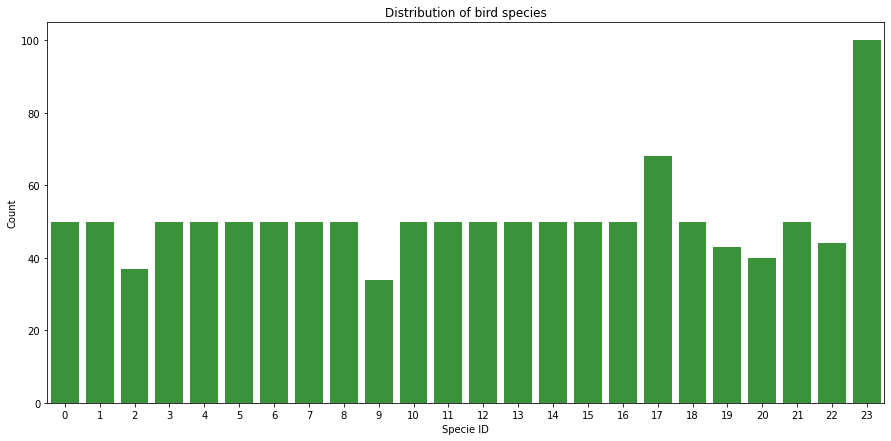

In [3]:
data = pd.read_csv('train_tp.csv')
fig, ax = plt.subplots(figsize=(15,7))

sns.countplot(x=data.species_id, color='tab:green', ax=ax);
ax.set_title('Distribution of bird species');
ax.set_xlabel('Specie ID')
ax.set_ylabel('Count');

**Figure 1** Distribution of bird specie

It is possible that a single audio recording will contain multiple species or multiple instance of the same specie such as the 03b96f209.flac recording id which contains two instances of specie_id 16 at 30-32 seconds and 49-51 seconds of the audio clip (Exhibit 1).

In [4]:
import IPython.display as ipd
audio_data = '03b96f209.flac'
ipd.Audio(audio_data)

**Exhibit 1** Audio recording that contains two specie instances.

### 3.1 Data Processing Pipeline

The data will be processed using dask library and amazong web service architecture. The preprocessing code was done in a separate notebook `(BDCC Preprocessing.ipynb)`.

1. Data Conversion
2. Feature engineering or conversion

#### 3.1.1 Data Conversion

Parallelizing loading of the audio files using different cluster is a challenge as the librosa library does not directly read from the s3 bucket. To prepare for parallelization, we handled the data through a single machine and saved it as a parquet file in the s3 bucket. Below is a snapshot of the code from `BDCC Preprocessing.ipynb` which reads the audio files, converts it to a numpy array and save to a parquet or pickle file in the s3 bucket.

#### 3.1.2 Test Data

The test data will be loaded based on the helper csv file in the competion. The helper csv file contains the timeframe and the frequency range where the sound of a specific bird specie can be heard.

In [ ]:
def load_audio(data):
    """
    Convert audio into numpy. Return the numpy, sampling rate and species_id
    """
    try:        
        x , sr = librosa.load(f'rainforest/train/{data.recording_id}.flac')
        return x, sr, data.species_id
    except:
        return None
    
def save_parquet(data, filename):
    """
    Save the parquet to the s3 bucket
    """
    
    start = datetime.now()
    print(f'starting {start}')
    data.to_parquet(f's3://rainforest-connection/{filename}.pqt',
                    engine='pyarrow')
    end = datetime.now()
    print(f'Elapsed Time {end - start}')

audio_files = (data_tp
               .apply(load_audio, 
                      meta=(None, 'object'),
                      axis=1)
              )

data_tp['audio'] = audio_files.apply(lambda x: x[0], meta=(None, 'object'))
data_tp['sr'] = audio_files.apply(lambda x: x[1], meta=(None, 'object'))
save_parquet(data_tp,'test')

### 3.2 Train or Inference Data

Unlike the test data, the train data doesn't have a helper csv file where we can determine at what timeframe and frequency a specific specie can be heard. Although the data pipeline is similar, the processing of the train audio files will be done separately from the test dataset as to differentiate test and train dataset.

In [ ]:
#instantiate boto3 client
s3 = boto3.client('s3')

#read test audio files
files = glob.glob('rainforest/test/*')
audio_files = []

for idx, file in enumerate(files): 
    start = datetime.now()
    #load audio file and convert to numpy array
    wav, sr = librosa.load(file, sr=None)
    audio_files.append[[wav,sr]]
    
with open('train_output.pickle', 'wb') as handle:
    pickle.dump(audio_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#upload to s3 bucket
s3.upload_file(f'test_processed_audio.pkl', 'rainforest-connection', 
               f'test_processed_audio.pkl')

### 3.3 Feature Engineering

We can use the audio file to identify the bird specie as a time series data, however; there are alternative features to use in an audio format to classify audio signals. Waveplot, chroma and spectrograms could be used to classify audio signal by converting the problem from a time series problem to an image classification problem. 

For this project, we will be converting the segment of the birds audio into melspectrogram. Since the audio file has been converted into a numpy array and saved into a parquet file, we could now parallelize the creation of the melspectrogram using a dask cluster. The dask cluster contains 4 ec2 instance with 16gb memory for each instance.

Each melspectrogram will not be saved into an image, instead we will be preserving the numpy matrix values of the melspectrogram to manage processing time and diskspace. Below is a code snippet from `BDCC Preprocessing.ipynb` which reads the generated parquet file and converts the numpy audio representation into a melspectrogram.

The generation of the melspectrogram is separated into train data and test or inference data.

### 3.3 Train Data

The helper data contains the timeframe and the frequency range for a specific specie in an audio file. The objective of the test data is to collect the mel-spectrogram of the specific animal specie which will be used to train the neural network. Below is a code snippet from `BDCC Preprocessing.ipynb` in creating the mel-spectrogram.

In [ ]:
fft = 2048 # fast fourier transform window
hop = 512 # hop length

# Less rounding errors this way
sr = 48000 # sampling rate
length = 10 * sr
fp_train_len = 500
ctr = 0


def convert_melspec(data):    
    """
    Generate the mel-spectrogram from  the numpy audio representation.
    """
    x = data.audio
    sr = data.sr
    
    #Get the minimum and maximum timeframe for the specie
    t_min = float(data.t_min) * sr
    t_max = float(data.f_min) * sr
    
    #Get the minimum amd maximum frequency for the specie
    fmin = data.f_min
    fmax = data.f_max
    
    #Standardize the shape of the mel-spectrogram
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    
    if beginning < 0:
            beginning = 0
    ending = beginning + length

    if ending > len(x):
        ending = len(x)
        beginning = ending - length
        
    #slice the corresponding audio file to retrieve the specie part
    slice_img = x[int(beginning):int(ending)]
    
    #generate mel-spectrogram
    xs = librosa.feature.melspectrogram(slice_img, n_fft=fft, hop_length=hop, 
                                    sr=sr, fmin=fmin, fmax=fmax, power=1.5)
    
    #convert amplitude to decibel
    xdb = librosa.amplitude_to_db(abs(xs))
    
    
    plt.ioff()
    
    #generate image
    mel = librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.axis('off')
    
    #remove margins
    plt.margins(0,0)
    plt.tight_layout()
    
    fig = plt.gcf()
    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer

    #generate the image array instead of saving and displaying the image
    img_arr = np.frombuffer (canvas.tostring_rgb(), dtype='uint8')
    img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    #one hot encode the specie
    specie = np.zeros(24)
    specie[data.species_id] = 1         
    
    return img_arr, specie

start = datetime.now()
melspec_temp = (
                processed_audio
                .apply(convert_melspec, meta=(None, 'object'),
                       axis=1)
               )
#separate the specie and the mel-spectrogram
melspec_temp = melspec_temp.explode().to_dask_array()

data = melspec_temp.compute()

#x value corresponds to the mel-spectrogram while y corresponds to the target
x = data[::2]
y = data[1::2]
end = datetime.now()
print(f'Elapsed Time {end - start}')

### 3.4 Test or Inference Data

The test data was spliced on the specific timeframe and frequency where a specific audio is detected. In the train dataset, such information is not available and will need to be infered. As a solution, the generation of mel-spectrogram on the train data will be done multiple times for a single audio file. Each mel-spectrogram consists of a 5 second timeframe of the audio file. Starting form 0 seconds, each mel-spectrogram will step in an increment of 5 seconds until it reaches the end of the audio file. Below is a code snippet of `BDCC Preprocessing.ipynb` in creating a mel-spectrogram.

In [ ]:
predict_arr = []
images = []
file_names = []

with open('train_output.pickle', 'rb') as file:
    audio = pickle.load(file)

for idx, wav in enumerate(audio): 
    """
    Iterate through audio file in the pickle
    """
    
    #Start splicing from 0 seconds until 10 seconds
    t_lower = 0.0
    t_upper = 10.0
    t_min = 0
    t_max = 0 

    img_pred = []
    
    length = 10 * sr
    
    while t_upper <= (len(wav)/sr):
        t_min = t_lower * sr
        t_max = t_upper * sr         
        
        #standardize the shape of the mel-spectrogram
        center = np.round((t_min + t_max) / 2)
        beginning = center - length / 2
        if beginning < 0:
            beginning = 0

        ending = beginning + length
        if ending > len(wav):
            ending = len(wav)
            beginning = ending - length

        #splice the audio file
        sliced = wav[int(beginning):int(ending)]
                
        #Generate mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(sliced, sr=sr)
        
        #convert amplitude to decibel
        xdb = librosa.amplitude_to_db(abs(mel_spec))
        
        #dispaly mel-spectrogram
        librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
        
        plt.axis('off');
        fig = plt.gcf()
        canvas = FigureCanvas(fig)
        canvas.draw()
        
        #get the numpy value instead of displaying
        img_arr = np.frombuffer (canvas.tostring_rgb(), dtype='uint8')
        img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        img_pred.append(img_arr)
        t_lower = t_lower + 5
        t_upper = t_upper + 5
        
        #clear the figure to incease code efficiency
        plt.clf() 
    images.append(img_pred)

### 3.5 Mel Spectrogram

Converting an audio file into a numpy array generates a single dimension array which could easily be saved inside a dataframe and subsequently saved into multiple file formats such as parquet or csv. The creation of the melspectrogram, in constrast, generates a three dimension matrix which creates problem in saving to certain file formats. Given these constraints, we decided to save the data using pickle instead of parquet or csv files.

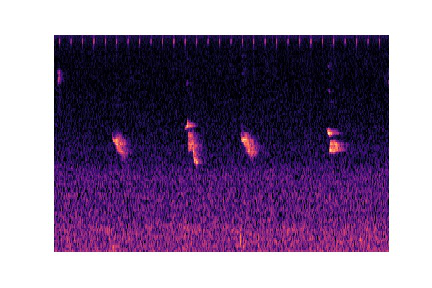

In [75]:
#Load the mel-spectrogram data and display image
with open('output.pickle', 'rb') as file:
    data = pickle.load(file)
    
Image.fromarray(data[0][0], 'RGB')

**Figure 2** Sample image of the mel-spectrogram of a specific specie from the dataset.

Note that after all the processing, the total data to be processed is now around 72.2 GB.

In [1]:
!aws s3 ls s3://rainforest-connection/ --recursive  | grep -v -E "(Bucket: |Prefix: |LastWriteTime|^$|--)" | awk 'BEGIN {total=0}{total+=$3}END{print total/1024/1024" MB"}'


72196 MB


### 3.6 Training

Each generated spectrogram will be used as an input in training the model. Instead of the competition's problem of classifying multiple species in a single audio file, we are identifying the specie that a specific audio timeframe and frequency belongs to. We will be using Adam optimizer with a learning rate of 0.0004 in training the neural network. For classifying the melspectrograms, we will be using **resnet50** with the following end layers in order:

1. GlobalAveragePooling2D
2. BatchNormalization
3. Dropout 0.5
4. Dense 24



In [69]:
#Load the train mel-spectrogram
with open('output.pickle', 'rb') as file:
    data = pickle.load(file)
x = np.stack(data[0])
y = np.stack(data[1])

#Instantiate the Stratified 5-Fold
kfold = StratifiedKFold()

x_train = []
y_train = []

x_test = []
y_test = []

### 3.7 Model Training

Dask ML supports integration with keras for deep learning, however; the library is wrapped through scikit learn library. Unfortunately scikitlearn library does not support more than 2 dimensions of data. Since we are working on images, our data contains 3 dimensions which is not currently supported by the scikitlearn keras wrapper for DaskML. We trained the model directly on keras library instead of going through the DaskML library and the scikit learn wrapper.

In [ ]:
callbacks = [ModelCheckpoint(filepath=f'best_model.h5', monitor='val_loss', 
                             save_best_only=True, verbose = 0),
             ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                               patience = 5, min_delta = 1e-5, mode = 'min',
                               verbose = 0)         
            ]

width, height = (288, 432)
resnet_base_model = ResNet50(input_shape=(width, height, 3),
                             include_top=False,
                            )

inputs = layers.Input((width,height, 3))
base = resnet_base_model(inputs)
base = layers.GlobalAveragePooling2D()(base)
base = layers.BatchNormalization()(base)
base = layers.Dropout(0.5)(base)
base = layers.Dense(24, activation="softmax")(base)

history = []

for train, test in kfold.split(x, y):

    model = models.Model(inputs=inputs, outputs=base)
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(from_logits = False),
                  metrics=['categorical_accuracy'])
    
    y_train = []
    y_test = []
    
    x_train = x[train]
    
    for target in y[train]:
        temp = np.zeros(24)
        temp[target] = 1
        y_train.append(temp)

    x_test = x[test]
    for target in y[test]:
        temp = np.zeros(24)
        temp[target] = 1
        y_test.append(temp)
    
    history.append(model.fit(x_train,
                    np.stack(y_train),
                    validation_data=(x_test, np.stack(y_test)),
                    epochs=20, verbose=0,
                    callbacks=callbacks))

In [73]:
#Calculate Metrics
test_acc=[]
train_acc=[]
test_loss=[]
train_loss=[]

for hist in history:
    test_acc.append(hist.history['val_categorical_accuracy'])
    train_acc.append(hist.history['categorical_accuracy'])
    test_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])

average_test_acc = np.mean(test_acc, axis=0)
average_train_acc = np.mean(train_acc, axis=0)
average_test_loss = np.mean(test_loss, axis=0)
average_train_loss = np.mean(train_loss, axis=0)

<div><span style="background-color: #779936; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> 4. RESULTS AND EVALUATION </span></div>

We separated the train-test data using stratified 5 fold split. This resulted to five iterations of model training for our data. We can observe from figure 3 that each iteration resulted to a minimum of 60% accuracy for k=1 and a high of 98% for k=5. By averaging the data we can approximate the overall accuracy of our model.

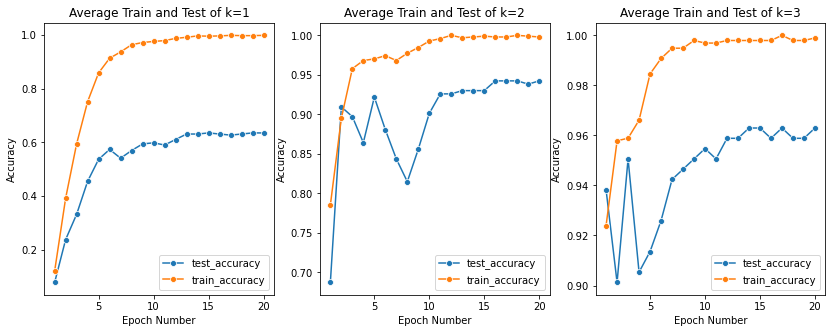

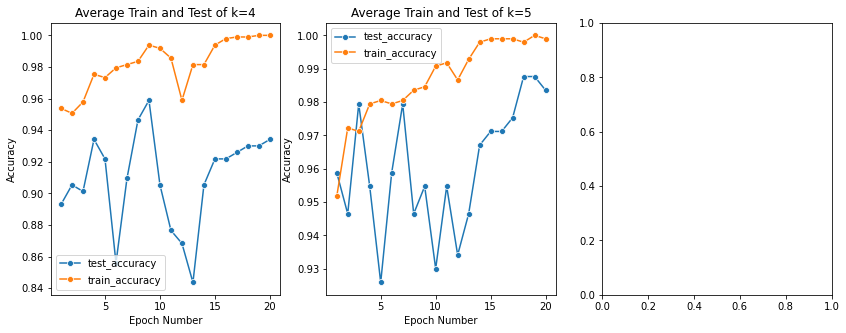

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(14,5))

for idx in range(3):
    sns.lineplot(y=test_acc[idx], x=list(range(1,len(average_test_acc)+1)), 
                 marker='o', ax=ax[idx], label='test_accuracy')
    sns.lineplot(y=train_acc[idx], x=list(range(1,len(average_test_acc)+1)), 
                 marker='o', ax=ax[idx], label='train_accuracy')


    ax[idx].set_title(f'Average Train and Test of k={idx+1}')
    ax[idx].set_xlabel('Epoch Number')
    ax[idx].set_ylabel('Accuracy');

fig, ax = plt.subplots(1, 3, figsize=(14,5))
for idx in range(3):
    
    if idx != 2:
        sns.lineplot(y=test_acc[idx+3], 
                     x=list(range(1,len(average_test_acc)+1)), 
                     marker='o', ax=ax[idx], label='test_accuracy')
        sns.lineplot(y=train_acc[idx+3], 
                     x=list(range(1,len(average_test_acc)+1)), 
                     marker='o', ax=ax[idx], label='train_accuracy')


        ax[idx].set_title(f'Average Train and Test of k={idx+4}')
        ax[idx].set_xlabel('Epoch Number')
        ax[idx].set_ylabel('Accuracy');

**Figure 3** Different train-test accuracy per train-test split in a 5 fold stratification. The model resulted to a minimum of 59% accuracy and a maximum of 96% accuracy.

When averaging the accuracy of each of the stratified 5 fold train-test split, our model has performed an 85% test accuracy by averaging the result of each train and test data split (Figure 4). This is significantly higher than the 5.49% 1.25 proportion chance criteria of our dataset.

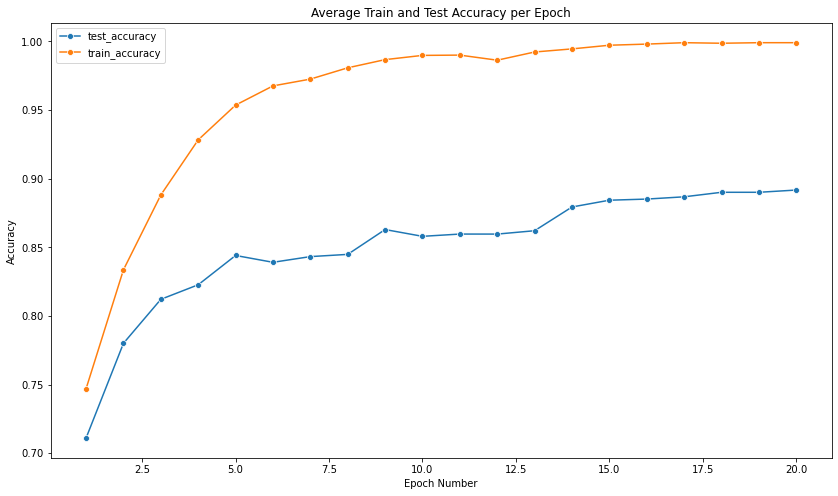

In [51]:
fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(y=average_test_acc, x=list(range(1,len(average_test_acc)+1)), 
             marker='o', ax=ax, label='test_accuracy')
sns.lineplot(y=average_train_acc, x=list(range(1,len(average_test_acc)+1)), 
             marker='o', ax=ax, label='train_accuracy')


ax.set_title('Average Train and Test Accuracy per Epoch')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Accuracy');

**Figure 4** Average accuracy of the 5 trained models using different stratified train-test split. The average resulted to an 85% accuracy of the model.

## Kaggle Competition Inference

The objective of the kaggle competition is to infer specific specie on a regular audio file, however; our methodology does not fit directly on the kaggle competition guidelines and objective. To address this, the following inference methodology is used:

    For every audio file to infer:
        1. Starting from 0 seconds until 5 seconds, create a mel spectrogram of the audio clip
        2. Use the model to predict the probability of one of the 24 specie being present in the audio clip mel-spectrogram
        3. Move the audio clip by 5 seconds and generate another mel-spectrogram and then infer or predict the result
        4. Replay until the code has reached the last second of the audio file
        
The creation of the mel-spectrogram for every 5 seconds was discussed in the pre-processing section.

In [88]:
with open('train_melspec.pickle', 'rb') as file:
    audio_files = pickle.load(file)

In [ ]:
model = load_model('best_model.h5')

predict_arr = []
file_names = []
img_pred = []
for audio in audio_files:

    pred = model.predict(np.stack([audio]))
    img_pred.append(pred)
    
    avg = np.array(img_pred).mean(axis=0)[0]    
    md = np.median(np.array(img_pred),axis=0)[0]
    
    mx = np.where(avg-md>0)[0]
    mn = np.where(avg-md<=0)[0]
    
    temp = np.zeros(24)
    temp[mx] = np.array(img_pred).max(axis=0)[0][mx]
    temp[mn] = np.array(img_pred).min(axis=0)[0][mn]
    
    predict_arr.append(temp)


The kaggle competition submission resulted to a maximum of `52.2%` score which is far behind the leading kaggle team which has a `97%` score in the leaderboards. Although our model could be used to detect multiple specie in a single audio file, there are rooms for improvement to increase the inference of multiple specie in a continuous audio file. Unfortunately, the kaggle train label is hidden from the participants and we could not evaluate the `52.2%` leaderboard score. 

<div><span style="background-color: #779936; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> 5. CONCLUSION </span></div>

Our model achieved an `85%` accuracy on a controlled dataset wherein the timeframe and the frequency range has been selected and plucked out of the audio file. This resulted to poor generalization of the model when used to infer species in an audio file, however; our model performs best when the audio file is cleaned and processed to determine the specie of frogs or birds when the audio file is focused on the frequency and/or the timeframe of the sound. 

The `52.2%` accuracy could possibly point out that our model could not generalize when noise are added in the audio or mel-spectrogram image despite the high accuracy of `85%`. Instead of directly doing inference on the raw data, researchers and conservation advocates can use our model and the methodology to infer the bird or frog specie of a specific sound. Alternatively, researchers could label the timeframe of the sound manually where a bird specie has been heard and use our model to identify the name of the specie in that specific timeframe.

Our project demonostrates the possibility to classify animal species from sound recordings using convolutional neural networks. Our model could successfully infer specific bird and frog specie on a controlled audio signal, however; inference from raw audio file needs more improvement but could still be useful nevertheless. Specie detection through adio could be an alternative surveying and inspection of forests because it is cheaper and can cover a vast area of land.

In improving the inference or generalization of our project or to increase the leaderboard score, we recommend the following methods:

1. Augment audio file by shifting pitch, adding gaussian noise, or changing speed. This will also increase the number of data points that the model could be trained on.
2. Kaggle provided a false positive data helper file which could be used to improve and compliment the true positive trained model of this project. 

Our project's scope could be extended or be used in different problems. Instead of identifying animal specie, our methodology could be used to detect outlier sound to detect anomalous activities such as poaching and illegal logging. Furthermore the methodology can be expanded to other soundscape and environments as long as they are correctly and properly annotated. A possible use for this model is detecting what type of vehicles that is recorded in an urban setting.

<div><span style="background-color: #779936; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> REFERENCES </span></div>

1 ESSC Inc _Low forest cover in the Philippines : Issues and responses at the community level_ Accessed at [https://essc.org.ph/content/lview/579/1/#:~:text=The%20Philippines%20is%20one%20of,of%20the%20total%20land%20area.]

2 Bosch, et. al. (2007). _Infrared image processing and its application to forest fire surveillance._ Institute of Telecommunications and Multimedia Applications (ITEAM), Polytechnical University of Valencia.

3 Mcroberts, Ronald (2009) _Probability- and model-based approaches to inference for proportion forest using satellite imagery as ancillary data_ Northern Research Station, U.S. Forest Service, Saint Paul, Minnesota, USA. Elsevier

4 Snaddon, J., Petrokofsky, G., Jepson, P., & Willis, K. J. (2013). _Biodiversity technologies: Tools as change agents._ Biology Letters, 9, 20121029.

5 Boyle, S., Smith, A., (2010). _Can landscape and species characteristics predict primate presence in forest fragments in the Brazilian Amazon?_ Biological Conservation, 143, 1134–1143

6 Potamitis, S. Ntalampiras, O. Jahn and K. Riede. (2014). _Automatic bird sound detection in long real-field recordings: applications and tools_ Appl. Acoust., 80, pp. 1-9, 10.1016/j.apacoust.2014.01.001

7 LeBien, J., Zhong, M., Campos-Cerqueira, M., Velev, J.P., Dodhia, R., Ferres, J.L. and Aide, T.M. (2020) _A pipeline for identification of bird and frog species in tropical soundscape recordings using a convolutional neural network_ Ecological Informatics, 59, 101113.
